In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import re
import os.path as osp
from tqdm.auto import tqdm
from glob import glob
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
from analysis.mem_ana import load_results#, parse_line_to_float
from analysis.utils import module_reload
from analysis.plot_matplotlib import plot_hist, export_figures
from analysis.import_data import import_true_reco

In [2]:
df = import_true_reco()

Using cached file from /nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/cache/compare_truejet_matchingreco.root_zhh_zzh.npy


In [3]:
repo_dir = '/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/MEM_HEP'
src_path = "/nfs/dust/ilc/user/bliewert/mem_integrate"
log_path = f"{src_path}/log"
log_files = glob(f'{log_path}/*.out')

In [4]:
print(len(log_files))

4096


In [19]:
from typing import Union

def get_type(df:pd.DataFrame, job)->Union[None,bool]:    
    event_id = 0
    with open(f'/nfs/dust/ilc/user/bliewert/mem_integrate/log/{job}.err', 'r') as file:
        Lines = file.readlines()
        
        for line in Lines:
            if 'MEM Integration 0.1' in line:
                event_id = int(line.split("INFO]")[1].split("[")[1].split("]")[0])
                print(event_id)
                break

    if event_id == 0:
        return None
    else:
        return int(df.iloc[event_id]['is_zhh'])

In [27]:
from typing import Optional

def get_ps_sampling( logfile:str, nperms_sig:int=3, df:Optional[pd.DataFrame]=None, silent:bool=False):    
    pssampling_zhh = { 'given': [], 'found': [], 'frac': [], 'is_adapting': [], }
    pssampling_zzh = { 'given': [], 'found': [], 'frac': [], 'is_adapting': [], }

    line_marker = 'PS points'
    switch_marker = 'result ='
    adapation_marker = 'Adaptation finished.'

    with open(logfile, 'r') as file:
        Lines = file.readlines()
        
        key_idx = 0
        elapsed_integrations = 0
        is_adapting = True
        
        for line in tqdm(Lines, disable=silent):
            # 1. BKG, 2. SIG
            if line.startswith(adapation_marker):
                is_adapting = not is_adapting
            
            if line.startswith(switch_marker):
                elapsed_integrations +=1
                is_adapting = not is_adapting
                
                if elapsed_integrations == nperms_sig:
                    key_idx += 1
                    
                continue
            
            if line.startswith(line_marker):
                numbers = re.findall(r'\d+', line)
                out = pssampling_zhh if key_idx == 0 else pssampling_zzh
                
                given = int(numbers[0])
                found = int(numbers[1])
                
                out['given'].append(given)
                out['found'].append(found)
                out['frac'].append(found/given)
                out['is_adapting'].append(is_adapting)
        
    if df is not None:
        is_zhh = get_type(df, os.path.basename(logfile).replace('.out', ''))
        
        pssampling_zhh['is_zhh'] = is_zhh*np.ones(len(pssampling_zhh['given']), dtype=bool)
        pssampling_zzh['is_zhh'] = is_zhh*np.ones(len(pssampling_zzh['given']), dtype=bool)
    
    pssampling_zhh = pd.DataFrame(pssampling_zhh)
    pssampling_zzh = pd.DataFrame(pssampling_zzh)
    
    return pssampling_zhh, pssampling_zzh

In [77]:
log = log_files[132]
print(log)

pssampling_zhh, pssampling_zzh = get_ps_sampling(log, df=df, nperms_sig=1)
len(pssampling_zzh), len(pssampling_zhh)

/nfs/dust/ilc/user/bliewert/vegas_consistency/log/108.out


100%|██████████| 3728/3728 [00:00<00:00, 343671.49it/s]

56400


(1916, 1782)

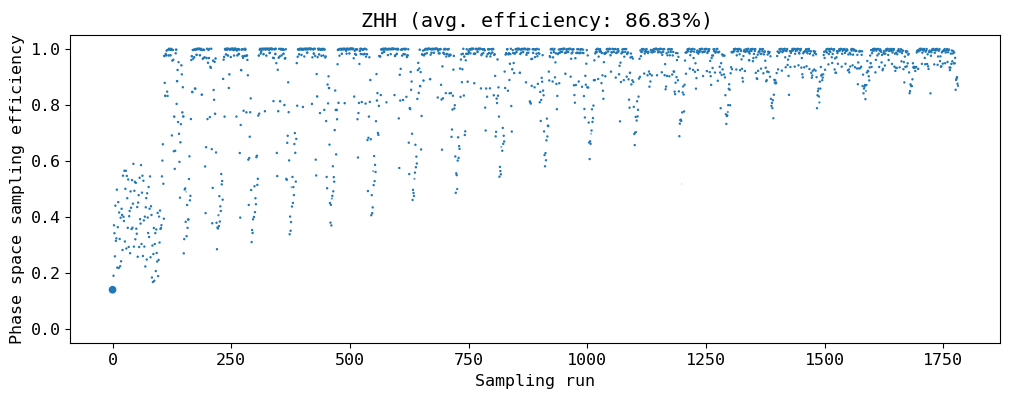

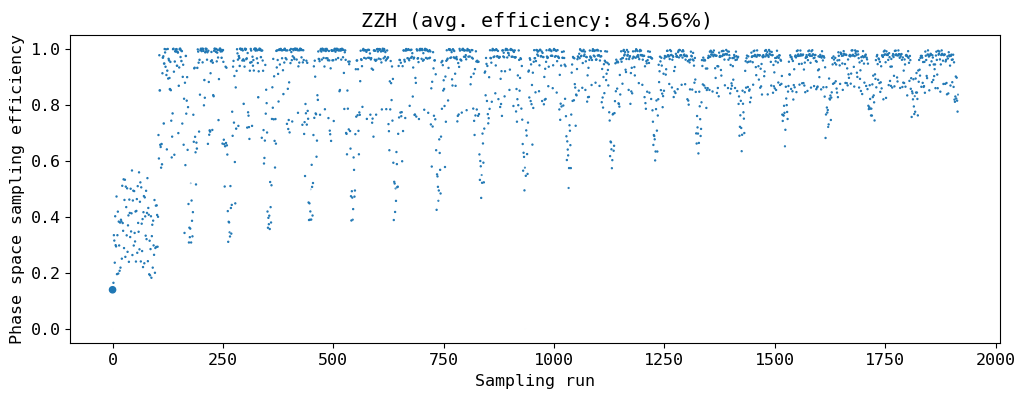

In [78]:
keys = ['ZHH', 'ZZH']
figures = []

for i, sampling in enumerate([pssampling_zhh, pssampling_zzh]):
    tot = np.sum(sampling['given'])
    factor = 1000 # len(sampling)*10
    
    fig, ax = plt.subplots(figsize=(12,4))
    ax.scatter(x=np.arange(len(sampling)), y=sampling['frac'], s=factor*sampling['given']/tot)
    ax.set_title(rf'{keys[i].upper()} (avg. efficiency: ${(sampling["found"]).sum()/tot*100:.2f}\%$)')
    ax.set_xlabel('Sampling run')
    ax.set_ylabel('Phase space sampling efficiency')
    figures.append(fig)
    plt.show()
    
export_figures(f'{repo_dir}/notebooks/results/5_ps_sampling_eff_example.pdf', figures)

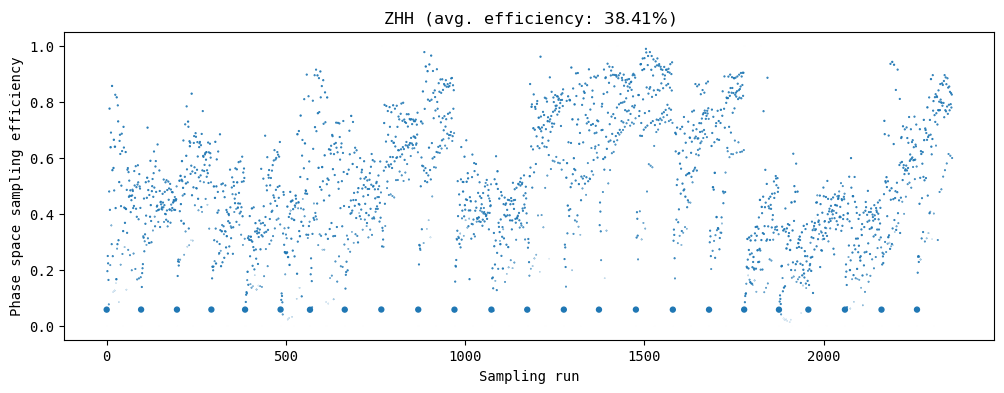

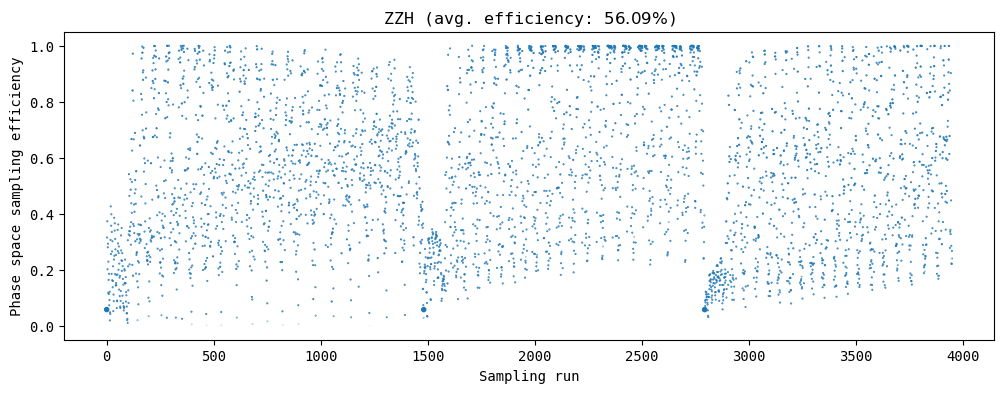

In [26]:
keys = ['ZHH', 'ZZH']
for i, sampling in enumerate([pssampling_zhh, pssampling_zzh]):
    tot = np.sum(sampling['given'])
    factor = 1000 # len(sampling)*10
    
    fig, ax = plt.subplots(figsize=(12,4))
    ax.scatter(x=np.arange(len(sampling)), y=sampling['frac'], s=factor*sampling['given']/tot)
    ax.set_title(rf'{keys[i].upper()} (avg. efficiency: ${(sampling["found"]).sum()/tot*100:.2f}\%$)')
    ax.set_xlabel('Sampling run')
    ax.set_ylabel('Phase space sampling efficiency')
    plt.show()

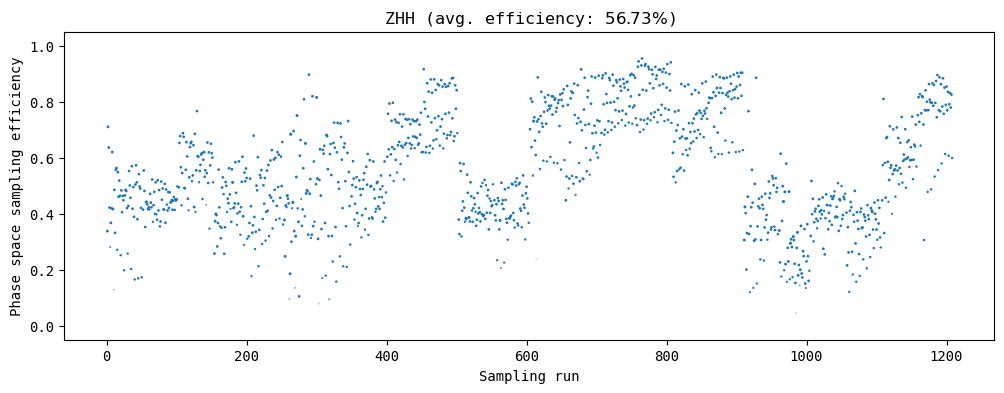

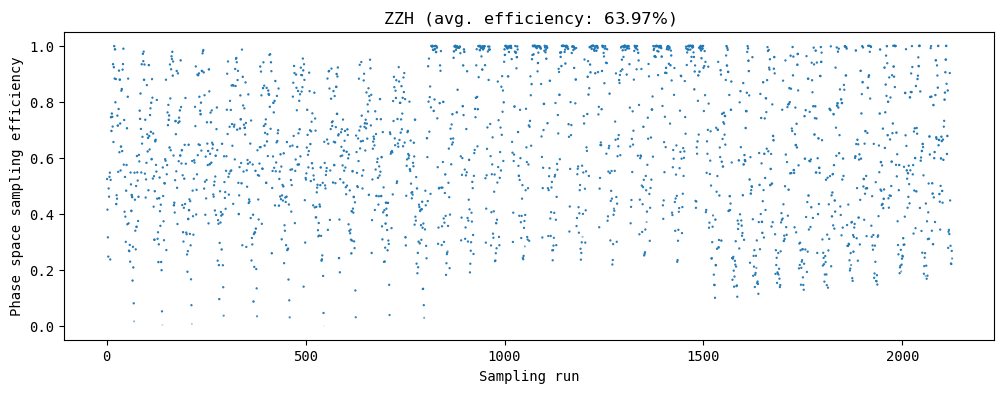

In [27]:
keys = ['ZHH', 'ZZH']
for i, dt in enumerate([pssampling_zhh, pssampling_zzh]):
    sampling = dt[~dt['is_adapting']]
    tot = np.sum(sampling['given'])
    factor = 1000 # len(sampling)*10
    
    fig, ax = plt.subplots(figsize=(12,4))
    ax.scatter(x=np.arange(len(sampling)), y=sampling['frac'], s=factor*sampling['given']/tot)
    ax.set_title(rf'{keys[i].upper()} (avg. efficiency: ${(sampling["found"]).sum()/tot*100:.2f}\%$)')
    ax.set_xlabel('Sampling run')
    ax.set_ylabel('Phase space sampling efficiency')
    plt.show()

Average sampling efficiencies

In [35]:
src_path = "/nfs/dust/ilc/user/bliewert/vegas_consistency"
log_path = f"{src_path}/log"
log_files = glob(f'{log_path}/*.out')
log_files

['/nfs/dust/ilc/user/bliewert/vegas_consistency/log/227.out',
 '/nfs/dust/ilc/user/bliewert/vegas_consistency/log/4.out',
 '/nfs/dust/ilc/user/bliewert/vegas_consistency/log/240.out',
 '/nfs/dust/ilc/user/bliewert/vegas_consistency/log/139.out',
 '/nfs/dust/ilc/user/bliewert/vegas_consistency/log/98.out',
 '/nfs/dust/ilc/user/bliewert/vegas_consistency/log/34.out',
 '/nfs/dust/ilc/user/bliewert/vegas_consistency/log/183.out',
 '/nfs/dust/ilc/user/bliewert/vegas_consistency/log/150.out',
 '/nfs/dust/ilc/user/bliewert/vegas_consistency/log/44.out',
 '/nfs/dust/ilc/user/bliewert/vegas_consistency/log/54.out',
 '/nfs/dust/ilc/user/bliewert/vegas_consistency/log/214.out',
 '/nfs/dust/ilc/user/bliewert/vegas_consistency/log/245.out',
 '/nfs/dust/ilc/user/bliewert/vegas_consistency/log/64.out',
 '/nfs/dust/ilc/user/bliewert/vegas_consistency/log/74.out',
 '/nfs/dust/ilc/user/bliewert/vegas_consistency/log/84.out',
 '/nfs/dust/ilc/user/bliewert/vegas_consistency/log/94.out',
 '/nfs/dust/ilc/us

In [60]:
result = {
    'given_zhh': [],
    'given_zzh': [],

    'found_zhh': [],
    'found_zzh': []
}

for log in tqdm(log_files):
    pssampling_zhh, pssampling_zzh = get_ps_sampling(log, silent=True, nperms_sig=1)
    
    result['given_zhh'].append(np.sum(pssampling_zhh['given']))
    result['given_zzh'].append(np.sum(pssampling_zzh['given']))
    
    result['found_zhh'].append(np.sum(pssampling_zhh['found']))
    result['found_zzh'].append(np.sum(pssampling_zzh['found']))

for key in result:
    result[key] = np.array(result[key])

100%|██████████| 256/256 [00:02<00:00, 91.63it/s]


In [61]:
print('Average efficiency ZHH:', np.sum(result['found_zhh'])/np.sum(result['given_zhh']))
print('Average efficiency ZZH:', np.sum(result['found_zzh'])/np.sum(result['given_zzh']))

Average efficiency ZHH: 0.6896411652444036
Average efficiency ZZH: 0.6732645277670384
